In this, we'll be going through old results and extracting 

1) the lda vector for each layer

2) the lda scaling for each layer 

the resulting combined output will then be constructed, with shape (31, 4096)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import glob 
import os 
import re

In [2]:
def extract_layer_index(s):
    match = re.search(r'layer_(\d+)_analyses', s)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"No layer index found in '{s}'")

In [3]:
def extract_reasoning_weight_information(layer_dir, save_location):
    """
    look within layer folder for results from layer 1 to 32 
    """ 
    all_folders = sorted(glob.glob(os.path.join(layer_dir,"layer_*/")), key=extract_layer_index)
    results = [None]*31

    for folder in all_folders:
        layer_idx = extract_layer_index(folder)
        if layer_idx>0:
            # get w vector 
            cur_w = np.load(
                os.path.join(folder, f"Layer_{layer_idx}_analysis_w_vector.npy")
            )

            # obtain the projected differences to determine the magntiude
            proj0 = np.load(
                os.path.join(folder, f"Layer_{layer_idx}_analysis_projected_0.npy")
            )
            proj1 = np.load(
                os.path.join(folder, f"Layer_{layer_idx}_analysis_projected_1.npy")
            )
            delta_mag = proj0.mean()-proj1.mean()

            results[layer_idx-1] = (delta_mag*cur_w)
    
    combined_results = np.stack(results)

    np.save(save_location, combined_results)

    return combined_results

Now let's extract this 

In [4]:
#combined_results = extract_reasoning_weight_information(layer_dir="layer_analyses", save_location="layer_analyses/combined_delta_vectors.npy")

combined_results = np.load("layer_analyses/combined_delta_vectors.npy")

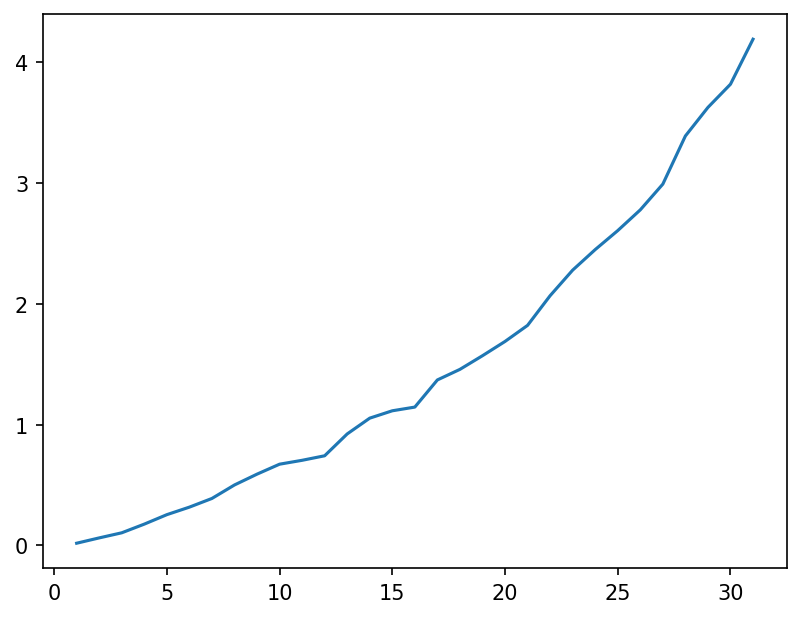

In [5]:
fig, ax = plt.subplots(dpi=150)

ax.plot(range(1, 32), np.sqrt((combined_results**2).sum(-1)))


In [6]:
def plot_cosine_similarity(matrix, title="Cosine Similarity Across Layers"):
    # Step 1: Normalize rows to unit length
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    normalized = matrix / (norms + 1e-8)  # avoid divide-by-zero

    # Step 2: Cosine similarity = dot product of unit vectors
    cosine_sim = normalized @ normalized.T  # shape: (N, N)

    # Step 3: Plot with matplotlib
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cosine_sim, cmap='viridis', interpolation='nearest')
    plt.title(title, fontsize=14)
    plt.xlabel("Layer Index")
    plt.ylabel("Layer Index")
    plt.colorbar(im, label='Cosine Similarity')
    plt.xticks(ticks=np.arange(len(matrix)))
    plt.yticks(ticks=np.arange(len(matrix)))
    plt.tight_layout()
    plt.show()


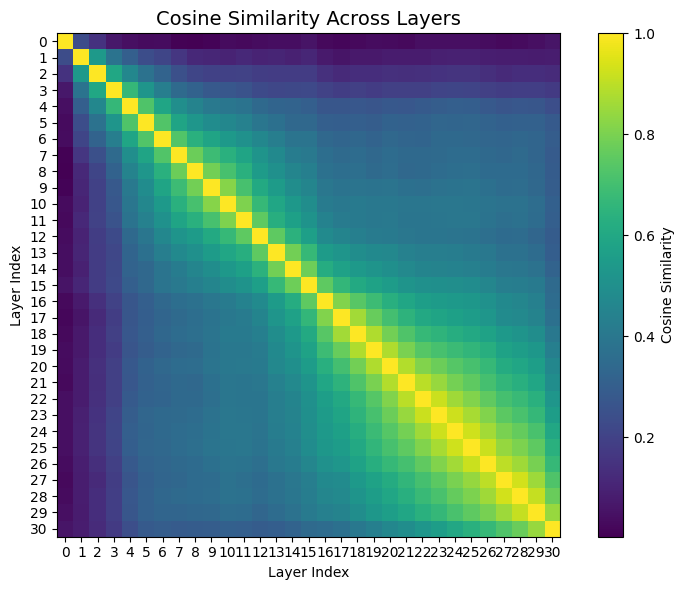

In [7]:
plot_cosine_similarity(combined_results)

# directional review

is this the difference from answering to thinking 

or is this thinking to answering 

----------------------------

going through the math, this vector points **in the direction of class 0, from class 1**

```
layerwise_analysis_results = [
    perform_token_normalized_analysis_suite(
        data_0 = {k:v[i] for k, v in output_think_dict.items()},
        data_1 = {k:v[i] for k, v in output_other_dict.items()},
        save_location = f"layer_{i}_analyses",
        descriptor=f"Layer {i} analysis"
    )
    for i in range(1, 32)
]
```

we used this when we ran this (data_0 = thinking, data_1 = answering)

meaning __adding__ this makes things look _more_ like a thinking zone 

# Subtracting the thinking vector 


We'll now want to _subtract_ this thinking vector from activations during generation, with different scalings 

let's write a function below to do this 


In [8]:
import torch
import math
from nnsight import CONFIG
from nnsight import LanguageModel
import nnsight
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import random
from collections import defaultdict
import yaml 
import pickle

# Save object to a file
def save_pickle(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

# Load object from a file
def load_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

load_dotenv()

/Users/sda1048/Desktop/interp/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [9]:
# read the api_key
CONFIG.set_default_api_key(os.environ.get('NDIF_KEY'))

# read the hf token
os.environ['HF_TOKEN'] = os.environ.get('HF_TOKEN')


NDIF_models = [
    "meta-llama/Meta-Llama-3.1-405B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B",
    "meta-llama/Meta-Llama-3.1-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
] 

# inexaustive list
non_NDIF_models = [
    "meta-llama/Meta-Llama-3.1-8B",
]

# choose a model 
llama_model_string = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# remote = use NDIF
remote = True 

if remote and (llama_model_string not in NDIF_models):
    remote = False 
    print("Model not available on NDIF")

# load a model
llama = LanguageModel(llama_model_string)

# load the shift vector
delta_vectors = torch.tensor(
    np.load("layer_analyses/combined_delta_vectors.npy")
)

In [10]:
# importing from my own code 
from activation_transplanting import *
from analysis_tools import *

In [11]:
def matches_pattern(s: str) -> bool:

    # extract meat 
    front = s[:len("<｜User｜>")]
    if not front == "<｜User｜>":
        return False 
    
    end = s[-len("<｜Assistant｜><think>\n"):]
    if not end == "<｜Assistant｜><think>\n":
        return False 
    
    return True

In [12]:
def generate_and_with_modified_activity(
    llama,
    source_string: str,
    num_new_tokens: int,
    temperature: float,
    delta_scale=1.0,
    delta_vectors=delta_vectors,
    remote=True,
    return_activity=False,
    max_layer_intervention = None,
):
    """
    given a source string, generate at most num_new_tokens
    use delta_vectors, a tensor of shape num_layers-1, model_dim
    to subtract delta_scale*delta_vectors[layer_idx-1] to the layer_index 
    activities. Optionally, return their activation_containers
    (this could be useful for examining the effects of the shifts 
    within the network)

    max_layer_intervention 
        None or an integer, indicating the maximum index layer 
        to which we should add our scaled delta vectors. 
        If None, add to all. 
        
    """
    # should be of the form "<｜User｜>{string}<｜Assistant｜><think>\n"
    assert matches_pattern(source_string), "doesnt match string pattern"

    if max_layer_intervention is None: 
        max_layer_intervention = float("inf")
    
    layers = llama.model.layers
    if return_activity:
        activation_container = ActivationContainer()

    with llama.generate(
        source_string,
        max_new_tokens=num_new_tokens,
        remote=remote,
        do_sample=False,
    ) as tracer:
        encoded_source_string = llama.tokenizer.encode(source_string)
        # Intervene on the first generation step only
        for idx in range(num_new_tokens):
            # for all layers at this index, perform the intervention
            # and colelction activations
            for layer_idx, layer in enumerate(layers):
                if 0<layer_idx<=max_layer_intervention:
                    # we subtract the shift vector 
                    layer.input[:, -1, :] -= delta_scale*delta_vectors[layer_idx-1, :]
                
                if return_activity:
                    if idx == 0:
                        # extract all activations for the <bos>+prompt
                        for cur_tok_idx, token_int in enumerate(encoded_source_string):
                            #if layer_idx==5:
                            #    print("z", cur_tok_idx)
                            activation_container.set_activation(
                                token_index=cur_tok_idx,
                                layer_index=layer_idx,
                                tensor=layer.input[:, cur_tok_idx, :].save(),
                                label="residual_input",
                            )
                    else:
                        # collect the activation residual inputs
                        activation_container.set_activation(
                            token_index=idx+len(encoded_source_string)-1,
                            layer_index=layer_idx,
                            tensor=layer.input[:, -1, :].save(),
                            label="residual_input",
                        )
            # Proceed to the next token generation step
            layers.next()

        # Save and retrieve the generator output tokens
        out = llama.generator.output.save()
    
    if return_activity:
        # now deal with the remaining token ints
        for token_idx, token_int in enumerate(out[0][:-1]):
            activation_container.set_tokens(
                token_index=token_idx,
                token_int=token_int,
                token_string=llama.tokenizer.decode(token_int),
            )
        
        activation_container.set_values()
        return activation_container, out[0] 

    return out[0]

Test this out

In [13]:
def read_prompts(file_path="holdout-reasoning-prompts.md"):
    """
    Read prompts from a text file and return them as a list of strings.
    
    Args:
        file_path (str): Path to the file containing reasoning prompts
        
    Returns:
        list: A list of strings, each containing a reasoning prompt
    """
    prompts = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines, headers, and category labels
                line = line.strip()
                if (line and 
                    not line.startswith('#') and 
                    not line.startswith('##') and
                    not line == ""):
                    
                    # Extract the prompt text by removing the number and period
                    parts = line.split('. ', 1)
                    if len(parts) > 1 and parts[0].isdigit():
                        prompt = parts[1]
                    else:
                        prompt = line
                        
                    prompts.append(prompt)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"Error reading prompts: {e}")
    
    return prompts

In [14]:
matches_pattern("<｜User｜>What is the square root of 12?<｜Assistant｜><think>\n")

True

In [15]:
logit_intensities = np.linspace(-5, 5, 30)
intensities = [0]+[float(x) for x in 1/(1+np.exp(-logit_intensities))]+[1]

In [16]:
print(intensities)

[0, 0.0066928509242848554, 0.009422642306984511, 0.013250971917260696, 0.01860550076850568, 0.026066561080887053, 0.036408609346018014, 0.050640567908538416, 0.0700314138515298, 0.09609566627120895, 0.1304992491604336, 0.1748373885662692, 0.23025063094724532, 0.2969072607902719, 0.37349751739318365, 0.45700301154629586, 0.542996988453704, 0.6265024826068166, 0.7030927392097283, 0.7697493690527548, 0.8251626114337308, 0.8695007508395666, 0.9039043337287912, 0.9299685861484701, 0.9493594320914616, 0.963591390653982, 0.973933438919113, 0.9813944992314942, 0.9867490280827395, 0.9905773576930155, 0.9933071490757153, 1]


In [17]:
test_out_0 = generate_and_with_modified_activity(
    llama,
    source_string="<｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>\n",
    num_new_tokens=300,
    temperature=0.0,
    delta_scale=0.007,
    delta_vectors=delta_vectors,
    remote=True,
    return_activity=False,
    max_layer_intervention = None,
)

2025-04-21 16:37:24,810 76d632a0-9bb5-4d0d-8dba-0c927e2224b0 - RECEIVED: Your job has been received and is waiting approval.
2025-04-21 16:37:25,356 76d632a0-9bb5-4d0d-8dba-0c927e2224b0 - APPROVED: Your job was approved and is waiting to be run.
2025-04-21 16:37:43,142 76d632a0-9bb5-4d0d-8dba-0c927e2224b0 - RUNNING: Your job has started running.
2025-04-21 16:38:05,760 76d632a0-9bb5-4d0d-8dba-0c927e2224b0 - COMPLETED: Your job has been completed.
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
llama.tokenizer.decode(test_out_0)

'<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>\nFirst, I recognize that the cake is divided into 12 equal slices.\n\nNext, I note that 5 of these slices are eaten.\n\nTo find out how many slices remain, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.\n\nFinally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.\n</think>\n\n**Solution:**\n\n1. **Total Slices:**  \n   The cake is cut into **12** equal slices.\n\n2. **Slices Eaten:**  \n   **5** slices are eaten.\n\n3. **Remaining Slices:**  \n   To find out how many slices are left, subtract the eaten slices from the total slices:\n   \n   \\[\n   12 \\text{ slices} - 5 \\text{ slices} = 7 \\text{ slices}\n   \\]\n\n4. **Fraction Remaining:**  \n   The fraction of the cake that remains is the ratio of the remaining slices to the total sli

In [19]:
holdout_prompts = read_prompts()[:25]

In [20]:
collection_dict = {p:[] for p in holdout_prompts}

In [21]:
from datetime import datetime

def get_date_string():
    return datetime.now().strftime("%Y-%m-%d")

In [22]:
for intensity in intensities:
    for hp in holdout_prompts:
        cur_output = generate_and_with_modified_activity(
            llama,
            source_string="<｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>\n",
            num_new_tokens=300,
            temperature=0.0,
            delta_scale=intensity,
            delta_vectors=delta_vectors,
            remote=True,
            return_activity=False,
            max_layer_intervention = None,
        )
        collection_dict[hp].append(
            (intensity, cur_output, llama.tokenizer.decode(cur_output))
        )

        save_pickle(collection_dict, f"saved_w_sweep_{get_date_string()}.pkl")



2025-04-21 16:39:09,773 0fae9620-0153-4f00-bcf5-937890a61fdb - RECEIVED: Your job has been received and is waiting approval.
2025-04-21 16:39:10,385 0fae9620-0153-4f00-bcf5-937890a61fdb - APPROVED: Your job was approved and is waiting to be run.
2025-04-21 16:39:24,824 0fae9620-0153-4f00-bcf5-937890a61fdb - RUNNING: Your job has started running.
2025-04-21 16:39:47,620 0fae9620-0153-4f00-bcf5-937890a61fdb - COMPLETED: Your job has been completed.
2025-04-21 16:40:27,075 f48ff28e-64f3-4d9a-83eb-db3478799a77 - RECEIVED: Your job has been received and is waiting approval.
2025-04-21 16:40:27,541 f48ff28e-64f3-4d9a-83eb-db3478799a77 - APPROVED: Your job was approved and is waiting to be run.
2025-04-21 16:40:41,634 f48ff28e-64f3-4d9a-83eb-db3478799a77 - RUNNING: Your job has started running.
2025-04-21 16:41:04,199 f48ff28e-64f3-4d9a-83eb-db3478799a77 - COMPLETED: Your job has been completed.
2025-04-21 16:41:43,824 4d1ec9b0-05db-4827-8888-add5a0cc08f4 - RECEIVED: Your job has been receive

ConnectionError: One or more namespaces failed to connect